In [1]:
# Importing the necessary libraries

import tensorflow as tf
import albumentations as albu
import numpy as np
import gc
import pickle
import matplotlib.pyplot as plt
from keras.callbacks import CSVLogger
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, accuracy_score, f1_score
from ModelArchitecture.DiceLoss import dice_metric_loss
from ModelArchitecture import Unet
from ImageLoader import ImageLoader2D

In [2]:
# Checking the number of GPUs available

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Setting the model parameters

img_size = 352
dataset_type = 'kvasir' # Options: kvasir/cvc-clinicdb/cvc-colondb/etis-laribpolypdb
learning_rate = 1e-4
seed_value = 58800
filters = 17 # Number of filters, the paper presents the results with 17 and 34
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

current_datetime = datetime.datetime.now()
ct = "_".join([str(current_datetime.year), str(current_datetime.month), str(current_datetime.day), str(current_datetime.hour), str(current_datetime.minute), str(current_datetime.second)])

model_type = "Unet"

progress_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) +  '_' + str(ct) + '.csv'
progressfull_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.txt'
plot_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.png'
model_path = 'ModelSaveTensorFlow/' + model_type + '_filters_' + str(filters) + '_' + str(ct)

EPOCHS = 150
min_loss_for_saving = 0.9

In [4]:
# Loading the data

X, Y = ImageLoader2D.load_data(img_size, img_size, -1, 'kvasir')

Resizing training images and masks: 100


100it [00:10,  9.33it/s]


In [5]:
from sklearn.model_selection import KFold

seed_value = 42
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed_value)

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    if fold == 4:
        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.111, shuffle=True, random_state=seed_value)

        print(f"Selected Fold: {fold + 1}")
        print("Training Set:", x_train.shape, y_train.shape)
        print("Validation Set:", x_valid.shape, y_valid.shape)
        print("Test Set:", x_test.shape, y_test.shape)

Selected Fold: 5
Training Set: (71, 352, 352, 3) (71, 352, 352, 1)
Validation Set: (9, 352, 352, 3) (9, 352, 352, 1)
Test Set: (20, 352, 352, 3) (20, 352, 352, 1)


In [6]:
# Splitting the data, seed for reproducibility
seed_value = 42
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle= True, random_state = seed_value)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.111, shuffle= True, random_state = seed_value)
print(f"Using random seed {seed_value}")
print(f"Train Set Size {len(x_train)}")
print(f"Valid Set Size {len(x_valid)}")
print(f"Test Set Size {len(x_test)}")


Using random seed 42
Train Set Size 80
Valid Set Size 10
Test Set Size 10


In [7]:
# Defining the augmentations

aug__horizon_train = albu.Compose([
    albu.HorizontalFlip(),
])

aug__vertical_train = albu.Compose([
    albu.VerticalFlip(),
])

aug__color_train = albu.Compose([
    albu.ColorJitter(brightness=(0.6,1.6), contrast=0.2, saturation=0.1, hue=0.01, always_apply=True),
])

aug__affine_train = albu.Compose([
    albu.Affine(),
])

def augment_images():
    x_train_out = []
    y_train_out = []

    for i in range (len(x_train)):
        horizon = aug__horizon_train(image=x_train[i], mask=y_train[i])
        vertical = aug__vertical_train(image=x_train[i], mask=y_train[i])
        color = aug__color_train(image=x_train[i], mask=y_train[i])
        affine = aug__affine_train(image=x_train[i], mask=y_train[i])
        x_train_out.append(horizon['image'])  
        y_train_out.append(horizon['mask'])
        x_train_out.append(vertical['image'])  
        y_train_out.append(vertical['mask'])
        x_train_out.append(color['image'])  
        y_train_out.append(color['mask'])
        x_train_out.append(affine['image'])  
        y_train_out.append(affine['mask'])

    return np.array(x_train_out), np.array(y_train_out)

In [8]:
# Creating the model

model = Unet.create_model(img_height=img_size, img_width=img_size, input_channels=3, out_classes=1, starting_filters=filters)

Starting UNet


In [9]:
# Compiling the model

model.compile(optimizer=optimizer, loss=dice_metric_loss)

In [10]:
# Training the model

step = 0

for epoch in range(0, EPOCHS):
    
    print(f'Training, epoch {epoch}')
    print('Learning Rate: ' + str(learning_rate))

    step += 1
        
    image_augmented, mask_augmented = augment_images()
    
    csv_logger = CSVLogger(progress_path, append=True, separator=';')
    
    model.fit(x=image_augmented, y=mask_augmented, epochs=1, batch_size=4, validation_data=(x_valid, y_valid), verbose=1, callbacks=[csv_logger])
    
    prediction_valid = model.predict(x_valid, verbose=0)
    loss_valid = dice_metric_loss(y_valid, prediction_valid)
    
    loss_valid = loss_valid.numpy()
    print("Loss Validation: " + str(loss_valid))
        
    prediction_test = model.predict(x_test, verbose=0)
    loss_test = dice_metric_loss(y_test, prediction_test)
    loss_test = loss_test.numpy()
    print("Loss Test: " + str(loss_test))
        
    with open(progressfull_path, 'a') as f:
        f.write('epoch: ' + str(epoch) + '\nval_loss: ' + str(loss_valid) + '\ntest_loss: ' + str(loss_test) + '\n\n\n')
    
    if min_loss_for_saving > loss_valid:
        min_loss_for_saving = loss_valid
        print("Saved model with val_loss: ", loss_valid)
        model.save(model_path)
        
    del image_augmented
    del mask_augmented

    gc.collect()

Training, epoch 0
Learning Rate: 0.0001
80/80 [==============================] - 13s 106ms/step - loss: 0.5993 - val_loss: 0.8596
Loss Validation: 0.8581338
Loss Test: 0.90392995
Saved model with val_loss:  0.8581338


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


Training, epoch 1
Learning Rate: 0.0001
80/80 [==============================] - 8s 98ms/step - loss: 0.4762 - val_loss: 0.6936
Loss Validation: 0.6878307
Loss Test: 0.81704015
Saved model with val_loss:  0.6878307


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


Training, epoch 2
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.4256 - val_loss: 0.5991
Loss Validation: 0.5941267
Loss Test: 0.66348433
Saved model with val_loss:  0.5941267


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


Training, epoch 3
Learning Rate: 0.0001
80/80 [==============================] - 8s 100ms/step - loss: 0.3999 - val_loss: 0.6725
Loss Validation: 0.66720957
Loss Test: 0.71448886
Training, epoch 4
Learning Rate: 0.0001
80/80 [==============================] - 8s 99ms/step - loss: 0.3643 - val_loss: 0.4381
Loss Validation: 0.4248693
Loss Test: 0.5285566
Saved model with val_loss:  0.4248693


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


Training, epoch 5
Learning Rate: 0.0001
80/80 [==============================] - 8s 101ms/step - loss: 0.3256 - val_loss: 0.4392
Loss Validation: 0.42591745
Loss Test: 0.54217607
Training, epoch 6
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.2995 - val_loss: 0.4161
Loss Validation: 0.40569085
Loss Test: 0.52877796
Saved model with val_loss:  0.40569085


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


Training, epoch 7
Learning Rate: 0.0001
80/80 [==============================] - 8s 99ms/step - loss: 0.2879 - val_loss: 0.3161
Loss Validation: 0.29680234
Loss Test: 0.30077195
Saved model with val_loss:  0.29680234


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


Training, epoch 8
Learning Rate: 0.0001
80/80 [==============================] - 8s 100ms/step - loss: 0.2587 - val_loss: 0.3054
Loss Validation: 0.2826913
Loss Test: 0.30126923
Saved model with val_loss:  0.2826913


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


Training, epoch 9
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.2429 - val_loss: 0.3520
Loss Validation: 0.33908427
Loss Test: 0.29052567
Training, epoch 10
Learning Rate: 0.0001
80/80 [==============================] - 8s 95ms/step - loss: 0.2253 - val_loss: 0.3127
Loss Validation: 0.2903502
Loss Test: 0.32604104
Training, epoch 11
Learning Rate: 0.0001
80/80 [==============================] - 8s 95ms/step - loss: 0.2205 - val_loss: 0.3254
Loss Validation: 0.30418128
Loss Test: 0.31239307
Training, epoch 12
Learning Rate: 0.0001
80/80 [==============================] - 8s 95ms/step - loss: 0.1957 - val_loss: 0.2907
Loss Validation: 0.27188742
Loss Test: 0.25491083
Saved model with val_loss:  0.27188742


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


Training, epoch 13
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.1845 - val_loss: 0.3082
Loss Validation: 0.29031414
Loss Test: 0.2833948
Training, epoch 14
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.1768 - val_loss: 0.3205
Loss Validation: 0.29946268
Loss Test: 0.32296157
Training, epoch 15
Learning Rate: 0.0001
80/80 [==============================] - 8s 96ms/step - loss: 0.1671 - val_loss: 0.3069
Loss Validation: 0.28746283
Loss Test: 0.3180462
Training, epoch 16
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.1542 - val_loss: 0.3055
Loss Validation: 0.28627378
Loss Test: 0.27268082
Training, epoch 17
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.1518 - val_loss: 0.3113
Loss Validation: 0.29554224
Loss Test: 0.33796507
Training, epoch 18
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.14

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


Training, epoch 25
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.1098 - val_loss: 0.3076
Loss Validation: 0.28171194
Loss Test: 0.3348304
Training, epoch 26
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.0925 - val_loss: 0.3209
Loss Validation: 0.30839056
Loss Test: 0.2511158
Training, epoch 27
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.1000 - val_loss: 0.2972
Loss Validation: 0.27537584
Loss Test: 0.29242188
Training, epoch 28
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.0914 - val_loss: 0.2964
Loss Validation: 0.2766391
Loss Test: 0.2279942
Training, epoch 29
Learning Rate: 0.0001
80/80 [==============================] - 8s 96ms/step - loss: 0.0933 - val_loss: 0.2690
Loss Validation: 0.24918991
Loss Test: 0.24295068
Saved model with val_loss:  0.24918991


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


Training, epoch 30
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.0811 - val_loss: 0.3157
Loss Validation: 0.29522097
Loss Test: 0.29462975
Training, epoch 31
Learning Rate: 0.0001
80/80 [==============================] - 8s 98ms/step - loss: 0.0864 - val_loss: 0.2614
Loss Validation: 0.24284095
Loss Test: 0.28354973
Saved model with val_loss:  0.24284095


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


Training, epoch 32
Learning Rate: 0.0001
80/80 [==============================] - 8s 98ms/step - loss: 0.0806 - val_loss: 0.2941
Loss Validation: 0.2701887
Loss Test: 0.23255235
Training, epoch 33
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.0756 - val_loss: 0.2591
Loss Validation: 0.242867
Loss Test: 0.25247943
Training, epoch 34
Learning Rate: 0.0001
80/80 [==============================] - 8s 98ms/step - loss: 0.0866 - val_loss: 0.2653
Loss Validation: 0.24618167
Loss Test: 0.23970681
Training, epoch 35
Learning Rate: 0.0001
80/80 [==============================] - 8s 98ms/step - loss: 0.0670 - val_loss: 0.2841
Loss Validation: 0.264194
Loss Test: 0.25645542
Training, epoch 36
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.0671 - val_loss: 0.2662
Loss Validation: 0.24640578
Loss Test: 0.22101128
Training, epoch 37
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.0737 

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


Training, epoch 39
Learning Rate: 0.0001
80/80 [==============================] - 8s 99ms/step - loss: 0.0719 - val_loss: 0.2775
Loss Validation: 0.24974304
Loss Test: 0.21593332
Training, epoch 40
Learning Rate: 0.0001
80/80 [==============================] - 8s 99ms/step - loss: 0.0644 - val_loss: 0.2482
Loss Validation: 0.23139644
Loss Test: 0.21336001
Saved model with val_loss:  0.23139644


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


Training, epoch 41
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.0678 - val_loss: 0.2634
Loss Validation: 0.24542284
Loss Test: 0.24580204
Training, epoch 42
Learning Rate: 0.0001
80/80 [==============================] - 8s 98ms/step - loss: 0.0577 - val_loss: 0.2533
Loss Validation: 0.23836148
Loss Test: 0.19785339
Training, epoch 43
Learning Rate: 0.0001
80/80 [==============================] - 8s 99ms/step - loss: 0.0619 - val_loss: 0.2806
Loss Validation: 0.2622527
Loss Test: 0.2589072
Training, epoch 44
Learning Rate: 0.0001
80/80 [==============================] - 8s 98ms/step - loss: 0.0643 - val_loss: 0.2469
Loss Validation: 0.22793704
Loss Test: 0.2114597
Saved model with val_loss:  0.22793704


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


Training, epoch 45
Learning Rate: 0.0001
80/80 [==============================] - 8s 98ms/step - loss: 0.0619 - val_loss: 0.2661
Loss Validation: 0.24619591
Loss Test: 0.2569369
Training, epoch 46
Learning Rate: 0.0001
80/80 [==============================] - 8s 98ms/step - loss: 0.0545 - val_loss: 0.2673
Loss Validation: 0.24477196
Loss Test: 0.20732588
Training, epoch 47
Learning Rate: 0.0001
80/80 [==============================] - 8s 98ms/step - loss: 0.0478 - val_loss: 0.2615
Loss Validation: 0.24442667
Loss Test: 0.20666134
Training, epoch 48
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.0523 - val_loss: 0.2596
Loss Validation: 0.23734534
Loss Test: 0.2520364
Training, epoch 49
Learning Rate: 0.0001
80/80 [==============================] - 8s 100ms/step - loss: 0.0505 - val_loss: 0.2676
Loss Validation: 0.24465132
Loss Test: 0.25254303
Training, epoch 50
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.0

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


Training, epoch 84
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.0335 - val_loss: 0.2419
Loss Validation: 0.22725254
Loss Test: 0.21424377
Saved model with val_loss:  0.22725254


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


Training, epoch 85
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.0360 - val_loss: 0.2822
Loss Validation: 0.26058912
Loss Test: 0.26529735
Training, epoch 86
Learning Rate: 0.0001
80/80 [==============================] - 8s 98ms/step - loss: 0.0347 - val_loss: 0.2482
Loss Validation: 0.22796047
Loss Test: 0.21800405
Training, epoch 87
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.0349 - val_loss: 0.2699
Loss Validation: 0.24485934
Loss Test: 0.23130333
Training, epoch 88
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.0305 - val_loss: 0.2756
Loss Validation: 0.25551546
Loss Test: 0.22303897
Training, epoch 89
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.0353 - val_loss: 0.2785
Loss Validation: 0.25419885
Loss Test: 0.23650122
Training, epoch 90
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2024_3_31_21_11_4\assets


Training, epoch 114
Learning Rate: 0.0001
80/80 [==============================] - 8s 99ms/step - loss: 0.0244 - val_loss: 0.2531
Loss Validation: 0.23347634
Loss Test: 0.23098654
Training, epoch 115
Learning Rate: 0.0001
80/80 [==============================] - 8s 100ms/step - loss: 0.0242 - val_loss: 0.2497
Loss Validation: 0.23062015
Loss Test: 0.20455086
Training, epoch 116
Learning Rate: 0.0001
80/80 [==============================] - 8s 98ms/step - loss: 0.0270 - val_loss: 0.2840
Loss Validation: 0.25919485
Loss Test: 0.22954464
Training, epoch 117
Learning Rate: 0.0001
80/80 [==============================] - 8s 98ms/step - loss: 0.0272 - val_loss: 0.2697
Loss Validation: 0.25056803
Loss Test: 0.21912807
Training, epoch 118
Learning Rate: 0.0001
80/80 [==============================] - 8s 98ms/step - loss: 0.0244 - val_loss: 0.2575
Loss Validation: 0.24032575
Loss Test: 0.19848031
Training, epoch 119
Learning Rate: 0.0001
80/80 [==============================] - 8s 98ms/step - l

Loading the model
3/3 [==============================] - 0s 23ms/step
results_Unet_17_kvasir.txt


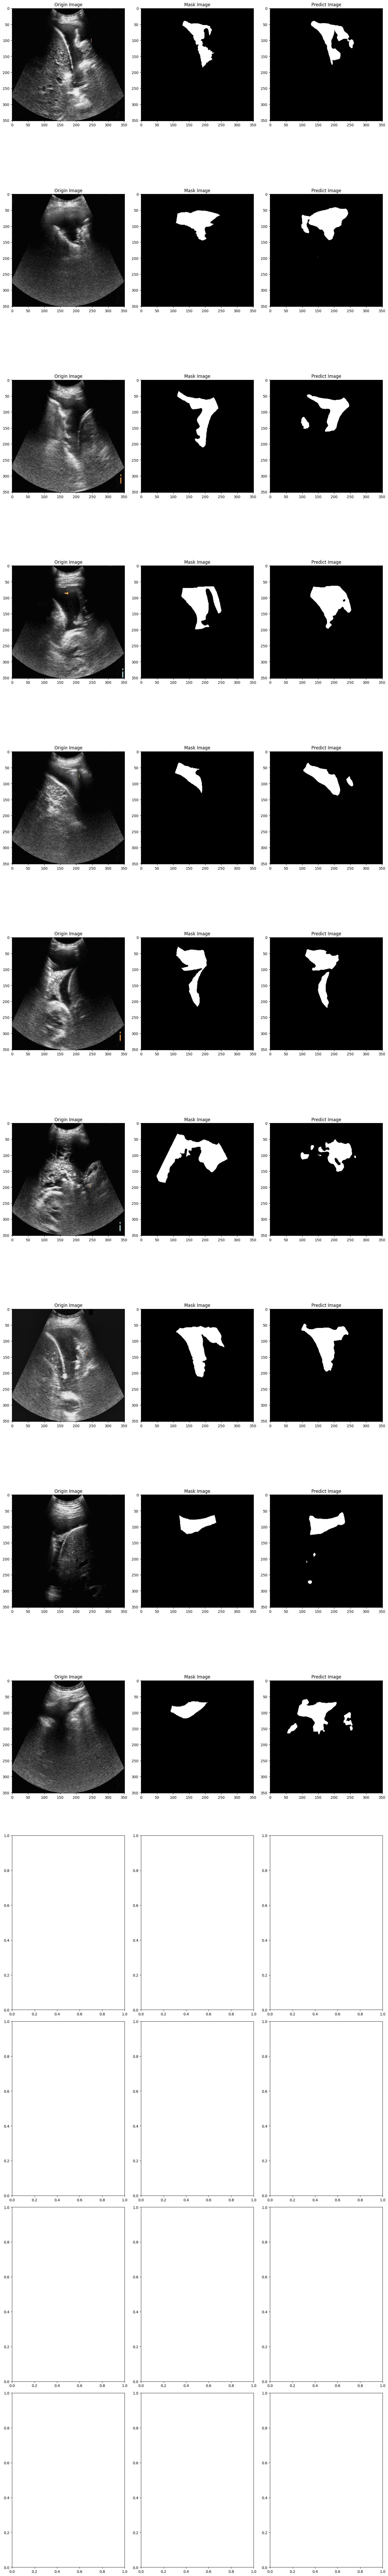

Predictions done
Dice finished
Miou finished
Precision finished
Recall finished
Accuracy finished
File done


In [11]:
# Computing the metrics and saving the results

print("Loading the model")

model = tf.keras.models.load_model(model_path, custom_objects={'dice_metric_loss':dice_metric_loss})

prediction_train = model.predict(x_train, batch_size=4)
prediction_valid = model.predict(x_valid, batch_size=4)
prediction_test = model.predict(x_test, batch_size=4)

fig, axs = plt.subplots(14, 3, figsize=(15, 100))

final_file = 'results_' + model_type + '_' + str(filters) + '_' + dataset_type + '.txt'
print(final_file)

for i in range(len(prediction_test)):
    origin = x_test[i]
    origin = origin.squeeze()
    axs[i, 0].imshow(origin, cmap='gray') 
    axs[i, 0].set_title('Origin Image')

    mask = y_test[i]
    mask = mask.squeeze()
    axs[i, 1].imshow(mask, cmap='gray') 
    axs[i, 1].set_title('Mask Image')
    
    pred = prediction_test[i]
    pred = pred.squeeze()
    axs[i, 2].imshow(pred, cmap='gray')
    axs[i, 2].set_title('Predict Image')
    
     # 計算個別數值
    dice_value = f1_score(np.ndarray.flatten(np.array(y_test[i], dtype=bool)),
                         np.ndarray.flatten(prediction_test[i] > 0.5))
    miou_value = jaccard_score(np.ndarray.flatten(np.array(y_test[i], dtype=bool)),
                              np.ndarray.flatten(prediction_test[i] > 0.5))
    precision_value = precision_score(np.ndarray.flatten(np.array(y_test[i], dtype=bool)),
                                      np.ndarray.flatten(prediction_test[i] > 0.5))
    recall_value = recall_score(np.ndarray.flatten(np.array(y_test[i], dtype=bool)),
                                np.ndarray.flatten(prediction_test[i] > 0.5))
    accuracy_value = accuracy_score(np.ndarray.flatten(np.array(y_test[i], dtype=bool)),
                                    np.ndarray.flatten(prediction_test[i] > 0.5))

    with open(final_file, 'a') as f:
        f.write(f'Metrics for sample {i + 1}:\n')
        f.write(f'Dice: {dice_value}\n')
        f.write(f'MIOU: {miou_value}\n')
        f.write(f'Precision: {precision_value}\n')
        f.write(f'Recall: {recall_value}\n')
        f.write(f'Accuracy: {accuracy_value}\n')
        f.write('\n')

plt.tight_layout()
plt.show()

print("Predictions done")

dice_train = f1_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
dice_test = f1_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
dice_valid = f1_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Dice finished")


miou_train = jaccard_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
miou_test = jaccard_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
miou_valid = jaccard_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Miou finished")


precision_train = precision_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                  np.ndarray.flatten(prediction_train > 0.5))
precision_test = precision_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                                 np.ndarray.flatten(prediction_test > 0.5))
precision_valid = precision_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                  np.ndarray.flatten(prediction_valid > 0.5))

print("Precision finished")


recall_train = recall_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                            np.ndarray.flatten(prediction_train > 0.5))
recall_test = recall_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                           np.ndarray.flatten(prediction_test > 0.5))
recall_valid = recall_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                            np.ndarray.flatten(prediction_valid > 0.5))

print("Recall finished")


accuracy_train = accuracy_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                np.ndarray.flatten(prediction_train > 0.5))
accuracy_test = accuracy_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                               np.ndarray.flatten(prediction_test > 0.5))
accuracy_valid = accuracy_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                np.ndarray.flatten(prediction_valid > 0.5))


print("Accuracy finished")

with open(final_file, 'a') as f:
    f.write(dataset_type + '\n\n')
    f.write('dice_train: ' + str(dice_train) + ' dice_valid: ' + str(dice_valid) + ' dice_test: ' + str(dice_test) + '\n\n')
    f.write('miou_train: ' + str(miou_train) + ' miou_valid: ' + str(miou_valid) + ' miou_test: ' + str(miou_test) + '\n\n')
    f.write('precision_train: ' + str(precision_train) + ' precision_valid: ' + str(precision_valid) + ' precision_test: ' + str(precision_test) + '\n\n')
    f.write('recall_train: ' + str(recall_train) + ' recall_valid: ' + str(recall_valid) + ' recall_test: ' + str(recall_test) + '\n\n')
    f.write('accuracy_train: ' + str(accuracy_train) + ' accuracy_valid: ' + str(accuracy_valid) + ' accuracy_test: ' + str(accuracy_test) + '\n\n\n\n')

print('File done')